# MCNP Output

- function to get the output: /Users/hkromer/02_PhD/02_Data/07.neutron_output/MCNP_neutron_output/fun_getNeutronOutputPer100muSv.py

In [1]:
import sys
sys.path.insert(0, '/Users/hkromer/02_PhD/02_Data/07.neutron_output/MCNP_neutron_output/')

from fun_getNeutronOutputPer100muSv import getNeutronOutputPer100muSv 
outputfolder = '/Users/hkromer/polybox/Thesis/Chapters/DetailedNeutronGeneratorCharacterization/Figures/'

In [2]:
import time
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import datetime
from matplotlib.ticker import AutoMinorLocator
import re

import os
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
plt.rc('text', usetex=True)
plt.rc('font', weight='bold')
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.tt'] = 'Arial'
matplotlib.rcParams['mathtext.cal'] = 'Arial'
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']

## Load countrate per nps

In [35]:
from scipy.interpolate import interp1d

fname = '/Users/hkromer/02_PhD/02_Data/13.new_chamber/2020-03-01.MCNP_2e8nps/df_total_countrate_per_nps_130.csv'
data = pd.read_csv(fname, index_col=0)
dose = 100  # assumed dose of 100 µSv/hr
d = np.arange(60, 240, 1)  # distance source to detector in cm
cps_per_dose = 0.79  # counts per dose, from the LB6411 manual
cps = cps_per_dose * dose  # counts in the LB6411

df_out = pd.DataFrame()  # output dataframe
df_out['distance'] = d  # position of the LB6411
lstDirection = ['N', 'S', 'W', 'E']  # directions where the tallies/detectors are in
for col in lstDirection:
    df_out[col] = 0  # Total neutron output for 100 µSv/hr for each direction

# interpolate total countrate per
for thisDir in lstDirection:
    this_df = data[ data['direction'] == thisDir ]
    x = this_df['distance'].values  # distance source to detector in MCNP
    y = this_df['ctPerS'].values  # counts per source particle in MCNP
#     inter = np.interp(d, x, y)  # interpolate results: counts per source particle if LB6411 where at that distance
    inter = interp1d(x, y, fill_value='extrapolate')
    neutron_output = cps / inter(d)  # neutron source output

    df_out[thisDir] = neutron_output

df_out = df_out.set_index('distance')
df = df_out

In [36]:
df

,N,S,W,E
distance,,,,
60,1.272367e+06,2.125529e+06,2.276770e+06,2.298212e+06
61,1.332111e+06,2.168315e+06,2.388353e+06,2.412225e+06
62,1.397742e+06,2.212859e+06,2.511436e+06,2.538141e+06
63,1.470175e+06,2.259271e+06,2.647896e+06,2.677926e+06
64,1.550526e+06,2.307672e+06,2.800036e+06,2.834006e+06
...,...,...,...,...
235,1.523528e+07,2.367526e+07,2.420051e+07,2.547305e+07
236,1.534081e+07,2.382333e+07,2.435083e+07,2.563931e+07
237,1.544781e+07,2.397326e+07,2.450303e+07,2.580776e+07


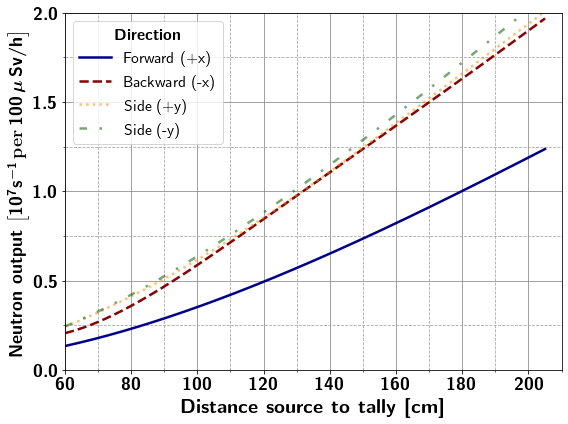

In [37]:
outputfolder = '/Users/hkromer/polybox/Thesis/Chapters/DetailedNeutronGeneratorCharacterization/Figures/'
figname = 'Neutron_output_relative_to_response_of_NP1_NEW_CHAMBER'

fig = plt.figure(figsize=(8, 6))
fs = 20
markersize = 8
scale_y = 1e7
lw = 2.5
# # North
# plt.plot(df.index.values, df['N'].values/scale_y, marker='o', color='darkblue', markersize=markersize, label=r'Forward (+x)')
# # South
# plt.plot(df.index.values, df['S'].values/scale_y, marker='s', color='darkred', markersize=markersize, label=r'Backward (-x)')
# # West
# plt.plot(df.index.values, df['W'].values/scale_y, marker='v', color='darkorange', markersize=markersize, label=r'Side (+y)', alpha=0.55)
# # East
# plt.plot(df.index.values, df['E'].values/scale_y, marker='d', color='darkgreen', markersize=markersize, label=r'Side (-y)', alpha=0.55)

df_interp = pd.DataFrame()
X = np.arange(60, 205+0.1, 0.1)
df_interp['X'] = X
# interpolate
for col in ['N', 'S', 'W', 'E']:
    poly = np.polyfit(df.index.values, df[col].values/scale_y,5)
    
    poly_y = np.poly1d(poly)(X)
    df_interp[col+'_poly'] = poly_y
linestyles = ['-', '--', "dotted", (0, (3, 5, 1, 5))]
# North
plt.plot(df_interp['X'].values, df_interp['N'+'_poly'].values, linestyle=linestyles[0], color='darkblue', markersize=markersize, label=r'Forward (+x)', linewidth=lw)
# South
plt.plot(df_interp['X'].values, df_interp['S'+'_poly'].values, linestyle=linestyles[1], color='darkred', markersize=markersize, label=r'Backward (-x)', linewidth=lw)
# West
plt.plot(df_interp['X'].values, df_interp['W'+'_poly'].values, linestyle=linestyles[2], color='darkorange', markersize=markersize, label=r'Side (+y)', alpha=0.55, linewidth=lw)
# East
plt.plot(df_interp['X'].values, df_interp['E'+'_poly'].values, linestyle=linestyles[3], color='darkgreen', markersize=markersize, label=r'Side (-y)', alpha=0.55, linewidth=lw)

ax1 = plt.gca()
# plt.yscale('log')
# take the same ylim as in the previous graph
ylim = ax1.get_ylim()

plt.xlim(60, 210)
plt.ylim(0, 2.0)
plt.yticks(np.arange(0,2.5,0.5))

# plt.ylabel(r"\textbf{Neutron output in }"+ r'$ [10^7 \frac{n}{s}] $' + '\n'+ r"\textbf{per 100} $ \frac{\mu Sv}{h}$", fontsize=fs)
plt.ylabel(r"\textbf{Neutron output $ \left[ 10^7 s^{-1} \, \textrm{per} \, 100\, \mu \,Sv/h \right]$", fontsize=fs-2)

plt.xlabel(r"\textbf{Distance source to tally [cm]}", fontsize=fs)

ax1.tick_params('x', colors='black', labelsize=fs-2)
ax1.tick_params('y', colors='black', labelsize=fs-2)
# minor ticks x
minor_locator = AutoMinorLocator(2)
ax1.xaxis.set_minor_locator(minor_locator)
# minor ticks y
minor_locator = AutoMinorLocator(2)
ax1.yaxis.set_minor_locator(minor_locator)
plt.grid(which="minor",ls="--", color='0.65')
plt.grid(which="major",ls="-", color='0.55')
leg = plt.legend(fontsize=fs-4)
leg.set_title(r"\textbf{Direction}", prop = {'size': fs-4})
plt.tight_layout()
plt.savefig(f'{outputfolder}/{figname}.pdf')
plt.show()

# neutron output per muSv/hr at 70, 75, 80 cm

In [58]:
PATH = '/Users/hkromer/02_PhD/02_Data/13.new_chamber/2020-03-01.MCNP_2e8nps/'
files = [f"{PATH}/{f}" for f in os.listdir(PATH) if 'countrate' in f]
HV = [re.findall(r'nps_(\d+).csv', f)[0] for f in files]
dfs = {}
for file, hv in zip(files, HV):
    data = pd.read_csv(file, index_col=0)
    dose = 100  # assumed dose of 100 µSv/hr
    d = np.arange(60, 240, 1)  # distance source to detector in cm
    cps_per_dose = 0.79  # counts per dose, from the LB6411 manual
    cps = cps_per_dose * dose  # counts in the LB6411

    df_out = pd.DataFrame()  # output dataframe
    df_out['distance'] = d  # position of the LB6411
    lstDirection = ['N', 'S', 'W', 'E']  # directions where the tallies/detectors are in
    for col in lstDirection:
        df_out[col] = 0  # Total neutron output for 100 µSv/hr for each direction

    # interpolate total countrate per
    for thisDir in lstDirection:
        this_df = data[ data['direction'] == thisDir ]
        x = this_df['distance'].values  # distance source to detector in MCNP
        y = this_df['ctPerS'].values  # counts per source particle in MCNP
    #     inter = np.interp(d, x, y)  # interpolate results: counts per source particle if LB6411 where at that distance
        inter = interp1d(x, y, fill_value='extrapolate')
        neutron_output = cps / inter(d)  # neutron source output

        df_out[thisDir] = neutron_output

    df_out = df_out.set_index('distance')
    dfs[hv] = df_out

In [63]:
data = pd.DataFrame()
for k in dfs.keys():
    df = dfs[k]
    df = df.loc[70:77, :]
    m = df.mean(axis=0)
    data[k] = m
    
data = data.T
data.index = data.index.astype(int)
data = data.sort_index()
data.to_csv("/Users/hkromer/02_PhD/02_Data/13.new_chamber/2020-03-01.MCNP_2e8nps/LUT_dose_output.csv")
data

,N,S,W,E
80,2.105532e+06,3.048065e+06,3.390954e+06,3.446946e+06
90,2.078324e+06,3.043728e+06,3.406939e+06,3.460306e+06
100,2.070428e+06,2.982207e+06,3.418122e+06,3.471954e+06
120,1.988476e+06,2.910691e+06,3.474807e+06,3.533212e+06
130,1.942131e+06,2.908419e+06,3.496682e+06,3.555830e+06


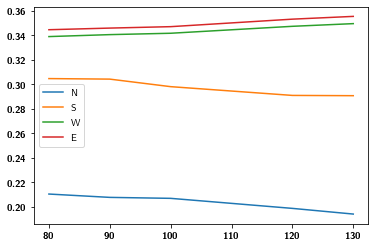

In [62]:
plt.plot(data.index, data['N'].values/1e7, label='N')
plt.plot(data.index, data['S'].values/1e7, label='S')
plt.plot(data.index, data['W'].values/1e7, label='W')
plt.plot(data.index, data['E'].values/1e7, label='E')
plt.legend()
plt.show()